# Linear regression: predicting patient medical costs

For this exercise we will use the data presented in [this](https://www.kaggle.com/mirichoi0218/insurance) dataset from Kaggle in which health insurance data is presented.


## Library downlowding and instalation


The first thing to do is to download the **[regressors](https://pypi.org/project/regressors/)** library that will help to do a deeper analysis on linear regression.

In [72]:
#!pip install --upgrade pip setuptools==57.5.0
!pip install setuptools==58 
!pip install regressors
#!easy_install regressors
#!apt-get -qq install -y regressors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Download the data
Download and see the data as a dataframe

In [59]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analyzing the data
It will be observed how the data of the variable to be predicted are distributed.

(1338, 7)


<Axes: >

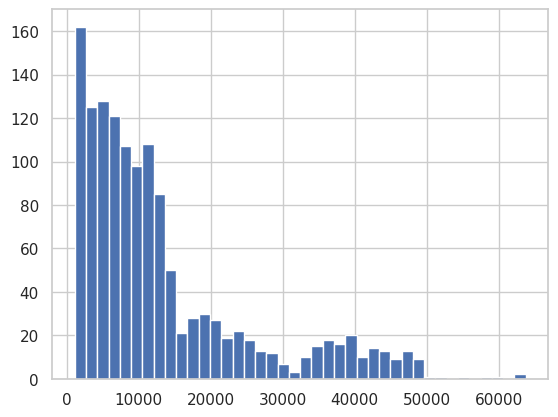

In [60]:
print(df.shape)
df.charges.hist(bins = 40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [27]:
df = pd.read_csv("insurance.csv")
outlier_data = df[df.charges>50000]
df = df[df.charges<50000]
outlier_data

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


One function that helps us to detect outliers in the data is the following

In [31]:
def detect_outliers(data,x):
  Q3=data[x].quantile(0.75)
  Q1=data[x].quantile(0.25)
  IQR = Q3-Q1
  superior = Q3 + (1.5*IQR)
  inferior = Q1 - (1.5*IQR)
  out_sup = data[data[x]>superior].index
  out_inf = data[data[x]<inferior].index

  outliers = []

  for i in out_sup:
    outliers.append(i)
    for j in out_inf:
      outliers.append(j)

  size = len(outliers)

  return outliers, size



df = pd.read_csv("insurance.csv")
charges_outliers = detect_outliers(df, "charges")


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

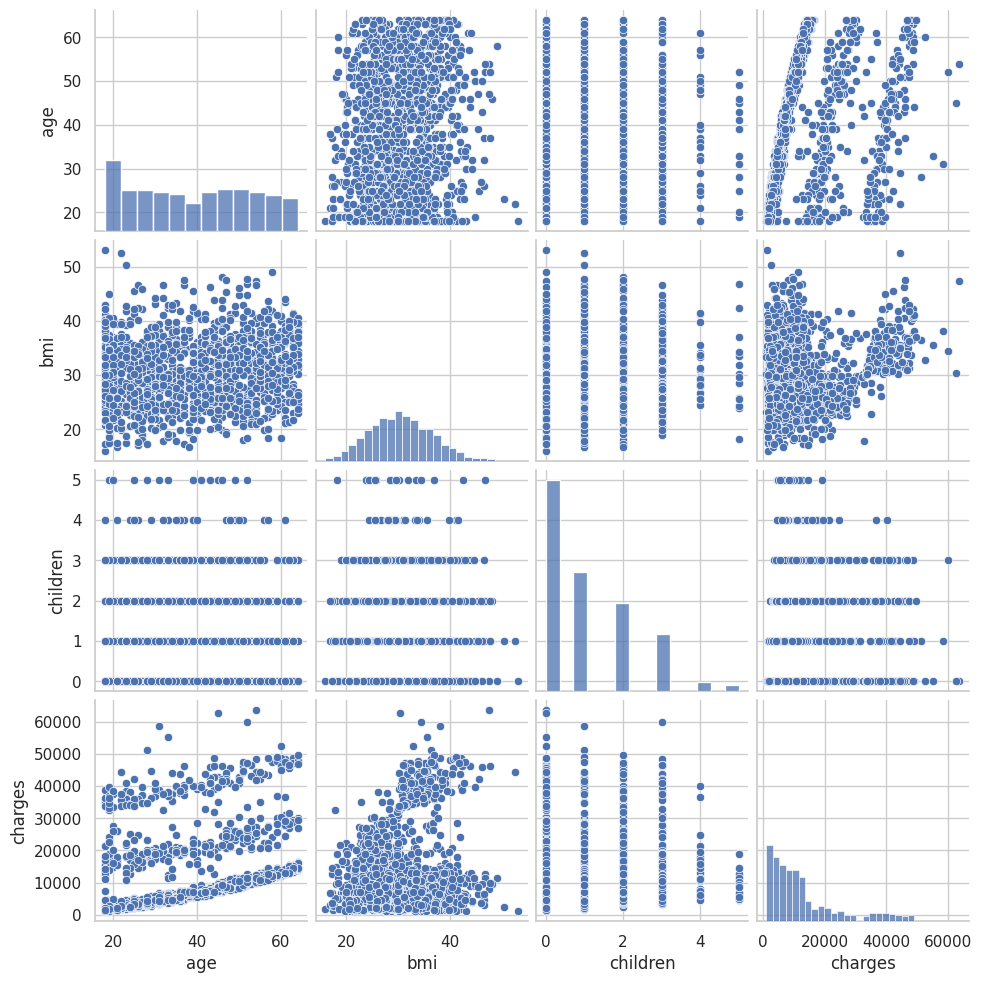

In [32]:
import matplotlib.pyplot as plt
sns.pairplot(df,height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<Axes: >

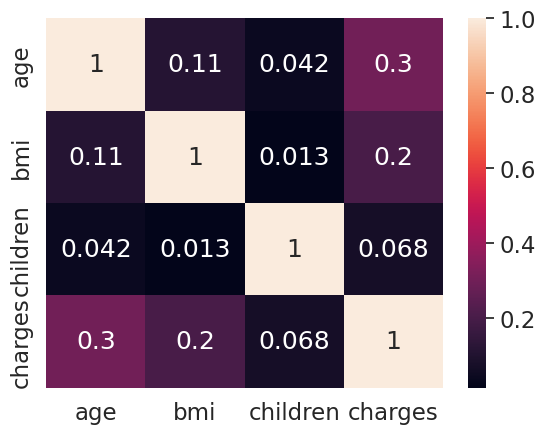

In [61]:
import numpy as np
numeric_cols = ["age","bmi","children","charges"]
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [62]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [78]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [67]:
y_pred.shape

(335, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [73]:
import sklearn.metrics as metrics
mse = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test,y_pred)

print("r2 error = ", r2.round(6))
print("mse error = ",mse.round(6))

r2 error =  0.7487
mse error =  0.356262


El siguiente código muestra un resumen general de los resultados.

In [79]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [81]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median     3Q    Max
-2.1728 -0.1414  0.0837 0.2221 0.8918


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.008187    0.027968  -0.2927  0.769910
region_southwest -0.030196    0.032079  -0.9413  0.347231
sex_male          0.011786    0.027934   0.4219  0.673357
children          0.041146    0.029205   1.4089  0.159796
age               0.301871    0.028412  10.6247  0.000000
smoker_yes        0.781636    0.028098  27.8184  0.000000
region_northwest  0.003205    0.033423   0.0959  0.923661
bmi               0.160246    0.028145   5.6937  0.000000
region_southeast -0.029748    0.032370  -0.9190  0.358756
---
R-squared:  0.75472,    Adjusted R-squared:  0.74870
F-statistic: 125.39 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

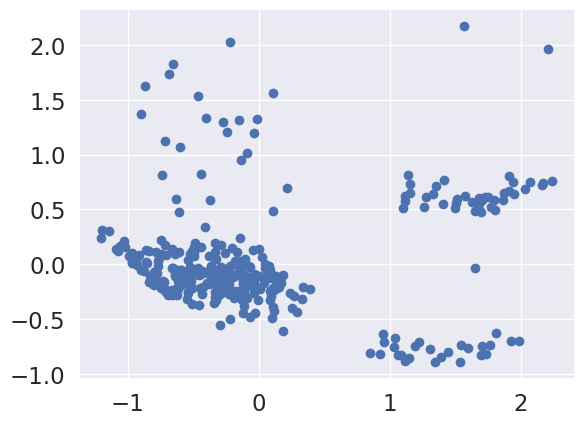

In [83]:
residuals = np.subtract(y_test,y_pred.reshape(-1))
plt.scatter(y_pred,residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [91]:
df_second = df.copy()
df_second["age2"]=df_second.age**2
df_second["sobrepeso"]=(df_second.bmi >= 30).astype(int)
df_second["sobrepeso*fumador"]=df_second.sobrepeso * df_second.smoker_yes
df_second.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age2,sobrepeso,sobrepeso*fumador
0,19,27.900,0,16884.92400,0,1,0,0,1,361,0,0
1,18,33.770,1,1725.55230,1,0,0,1,0,324,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0,784,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,1089,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,1024,0,0


Analizando el segundo modelo

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_cols = list(set(df_second.columns)-set(['charges']))
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [86]:
import sklearn.metrics as metrics
mse = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test,y_pred)

print("r2 error = ", r2.round(6))
print("mse error = ",mse.round(6))

r2 error =  0.871379
mse error =  0.188881


In [87]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [104]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-1.8642 0.0334   0.088 0.1372 0.3342


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept        -0.002158    0.019674  -0.1097  0.912729
age2               0.377808    0.102461   3.6873  0.000264
region_southwest  -0.042175    0.022278  -1.8931  0.059208
sobrepeso         -0.063894    0.030803  -2.0743  0.038822
sex_male          -0.024473    0.019616  -1.2476  0.213067
children           0.071849    0.020749   3.4628  0.000604
age               -0.064153    0.106611  -0.6018  0.547747
smoker_yes         0.446451    0.025659  17.3992  0.000000
region_northwest   0.002648    0.023232   0.1140  0.909317
sobrepeso*fumador  0.502705    0.027672  18.1666  0.000000
bmi                0.089765    0.030978   2.8977  0.004008
region_southeast  -0.029648    0.023584  -1.2571  0.209589
---
R-squared:  0.87138,    Adjusted R-squared:  0.86700
F-statistic: 198.93 on 11 features


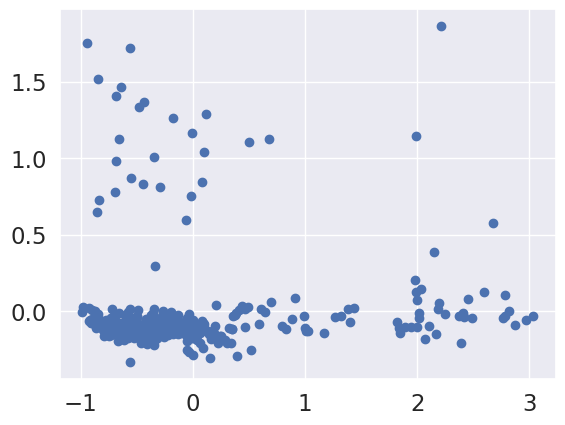

In [89]:
residuals = np.subtract(y_test,y_pred.reshape(-1))
plt.scatter(y_pred,residuals)
plt.show()

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from regressors import stats



def linear_regressor(data_frame,colums,regressor_data, stats="None",rounding=4):
  df = data_frame
  rgd = str(regressor_data)
  X_cols =list(set(df.columns)-set([rgd]))
  y_col = [rgd]
  X = df[X_cols].values
  y = df[y_col].values

  X_train, X_test, y_train, y_test = train_test_split(X,y)
  sc_x = StandardScaler().fit(X)
  sc_y = StandardScaler().fit(y)

  X_train = sc_x.transform(X_train)
  X_test  = sc_x.transform(X_test)
  y_train = sc_y.transform(y_train)
  y_test  = sc_y.transform(y_test)

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  model.intercept_ = model.intercept_[0]
  model.coef_ = model.coef_.reshape(-1)
  

  if stats.lower() == "stats":
    mse = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test,y_pred)
    y_test = y_test.reshape(-1)
    #stats.summary(model, X_test, y_test, X_cols))
    return model.intercept_.round(rounding), model.coef_.round(rounding), mse.round(rounding) ,r2.round(rounding)
  else:
    return model.intercept_, model.coef_

In [126]:
columns=['sex','smoker','region']
linear_regressor(df_second,columns,'charges', stats="stats")

(0.0001,
 array([ 0.2971, -0.0454, -0.0496, -0.013 ,  0.0698,  0.0087,  0.4461,
        -0.0226,  0.5105,  0.0726, -0.0483]),
 0.2146,
 0.8349)